# RNA-based Segmentation

This notebook showcases end-to-end RNA-based cell segmentation. This is done in two broad steps.

1. Identify individual nuclei from unspliced RNA signal.
2. From these nuclei, identify cells.

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/mnt/c/Users/phoen/Documents/GitHub/spateo-release')

import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st

plt.style.use('default')
plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data
`st.io.read_bgi_agg` reads in aggregated UMI counts per pixel.

In [3]:
adata = st.io.read_bgi_agg('data/SS200000135TL_D1_all_bin1.txt.gz', scale=0.5, scale_unit='um')
adata

AnnData object with n_obs × n_vars = 2000 × 2000
    uns: '__type', 'pp', 'spatial'
    layers: 'spliced', 'unspliced'

## 1. Nuclei segmentation

In this step, we segment and label individual nuclei. This is done by first segmenting the slice into RNA density bins, and then computing the marginal probability at each pixel that the pixel is occupied by a nucleus (the technical details of which we will ignore).

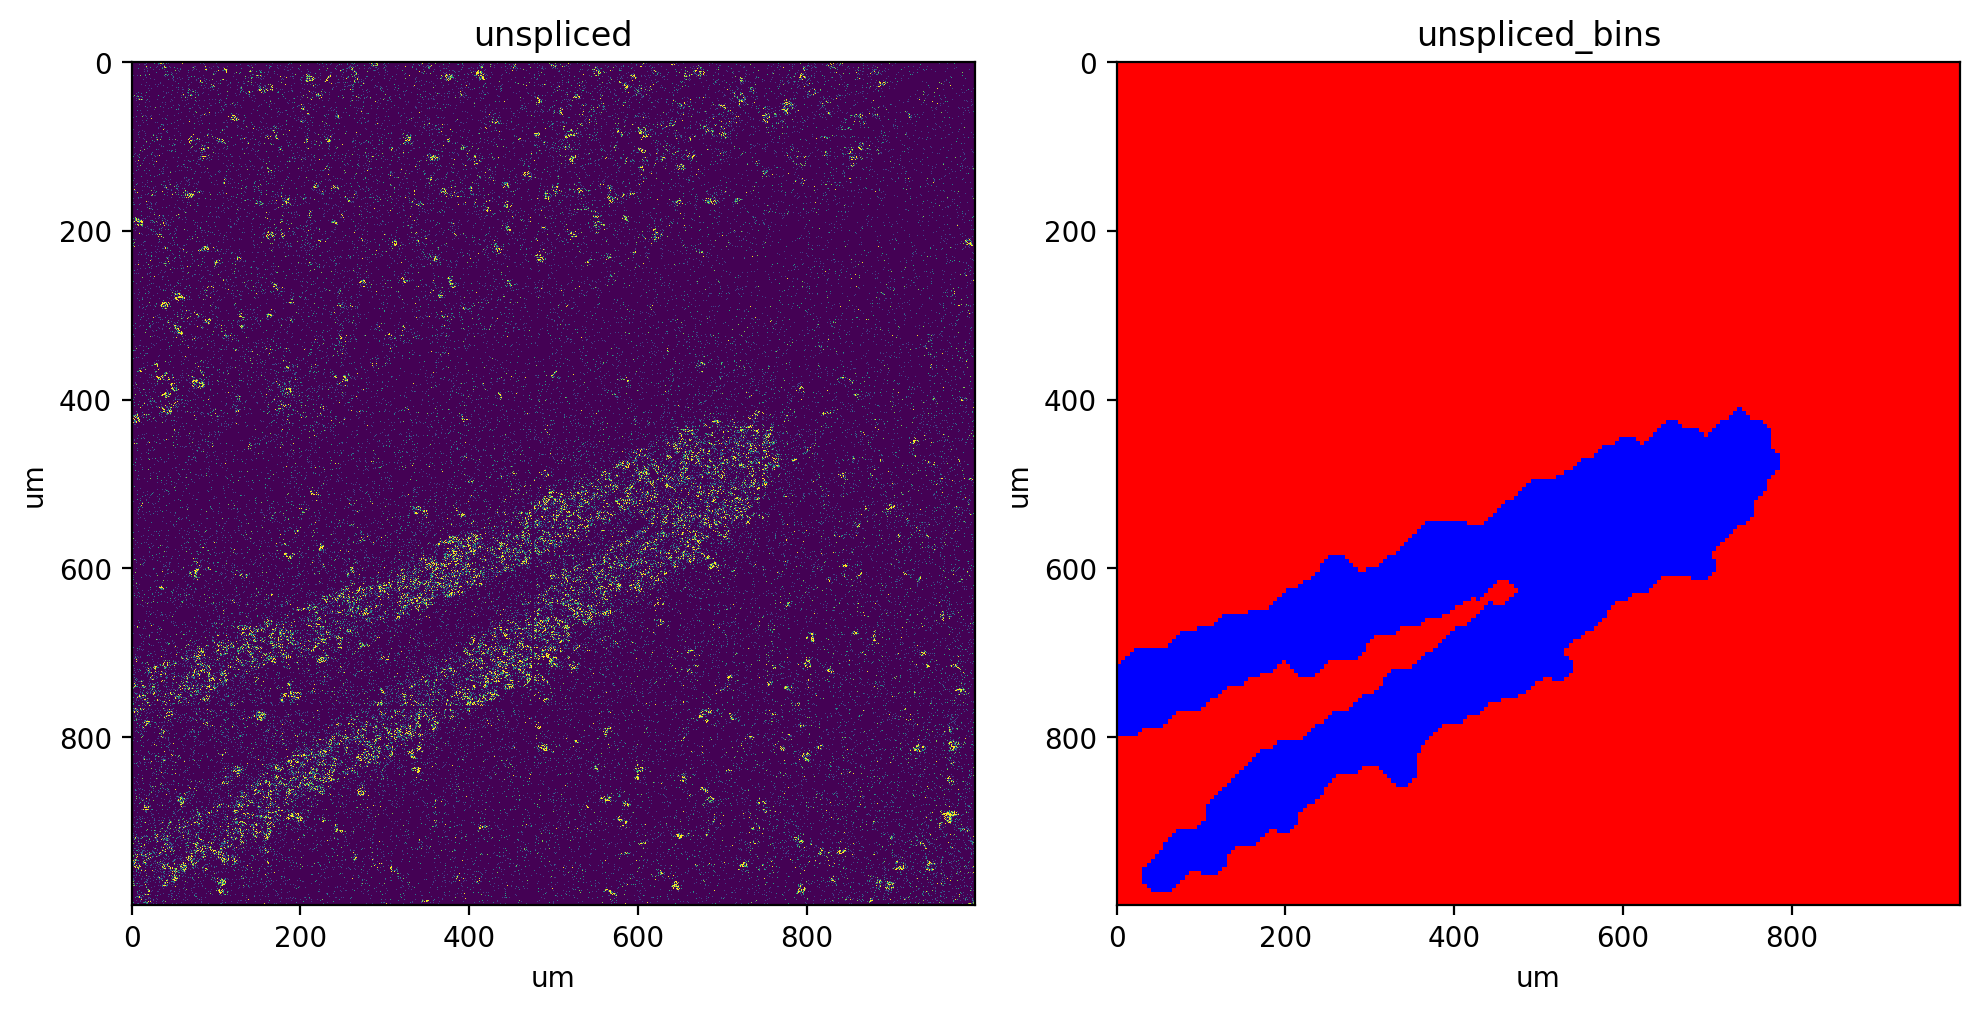

In [4]:
st.pp.segmentation.segment_densities(adata, 'unspliced', 10, k=7, distance_threshold=5, background=False)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'unspliced', vmax=5, ax=axes[0])
st.pl.imshow(adata, 'unspliced_bins', ax=axes[1], labels=True)

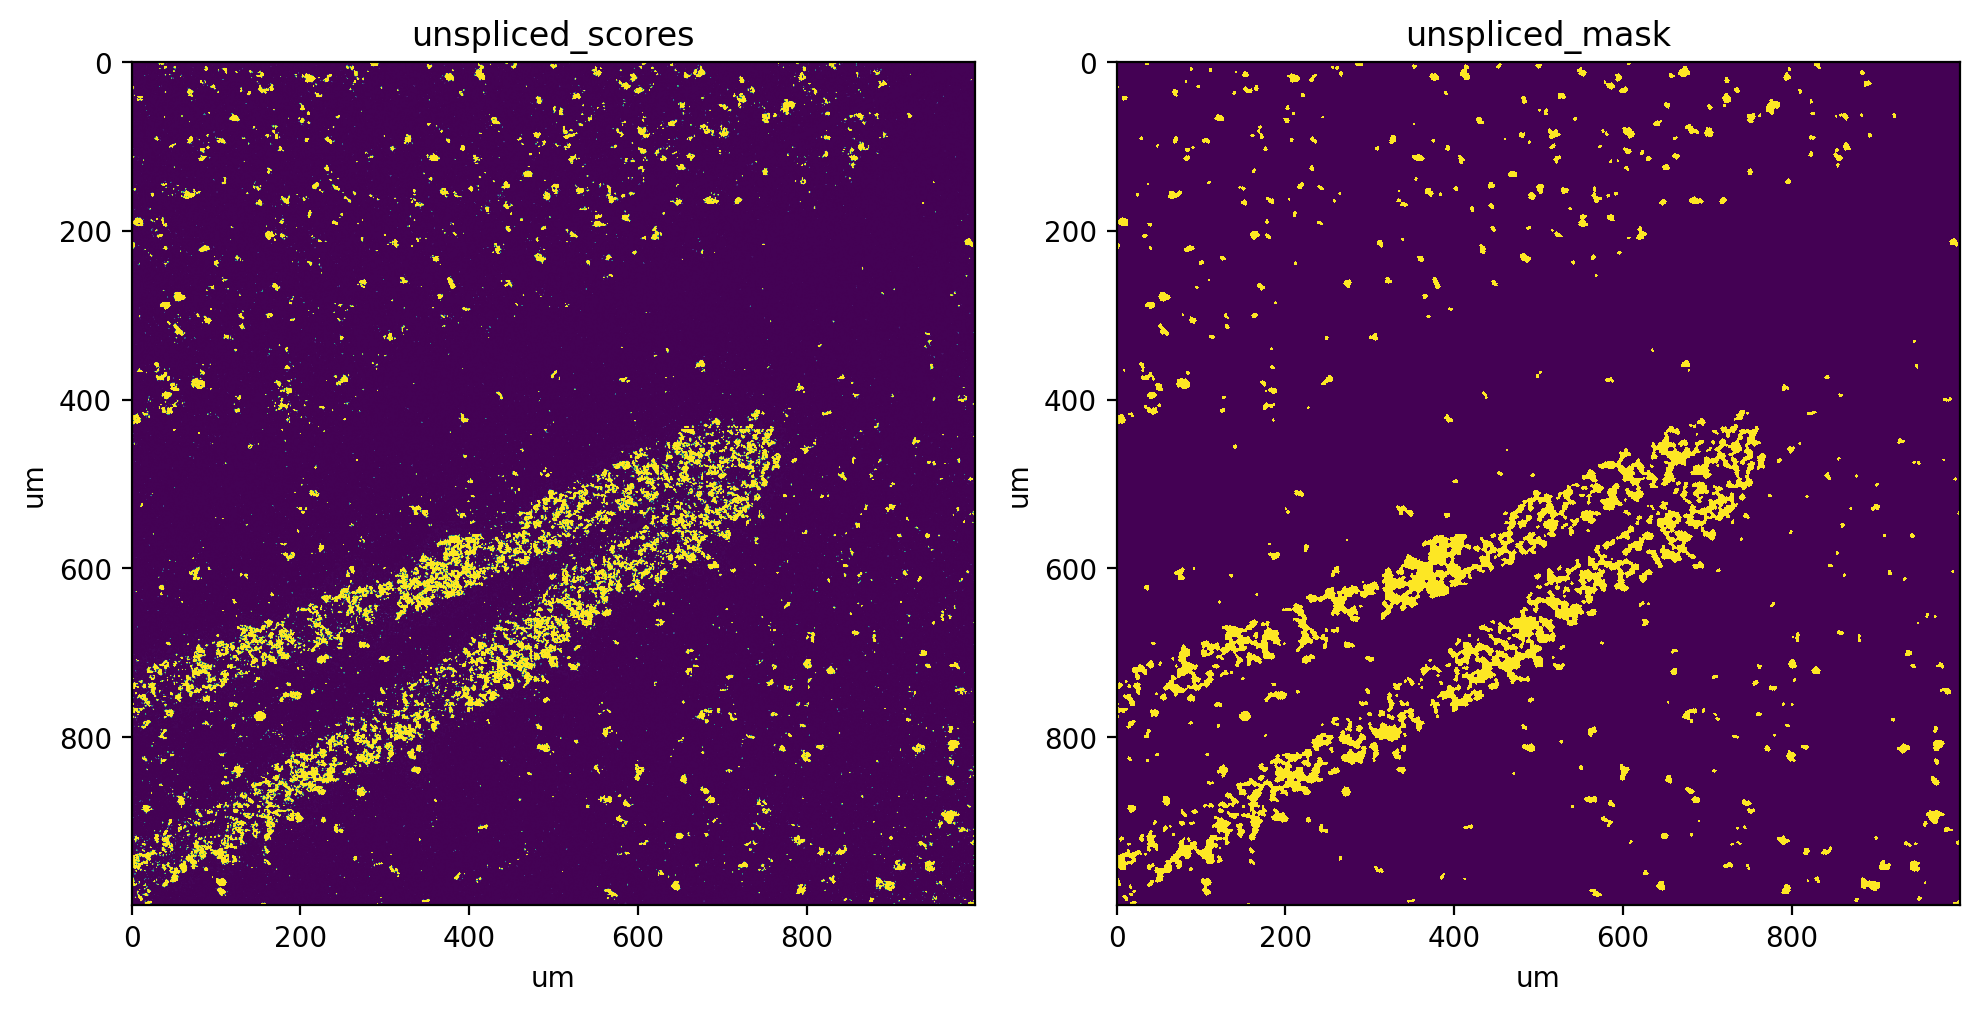

In [5]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'unspliced', k=5, method='EM+BP',
    em_kwargs=dict(downsample=0.01, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=0.7, q=0.3),
    mk=7,
)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'unspliced_scores', ax=axes[0])
st.pl.imshow(adata, 'unspliced_mask', ax=axes[1])

With the above nucleus mask, we try and identify individual nuclei.

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'unspliced_labels'}, xlabel='um', ylabel='um'>)

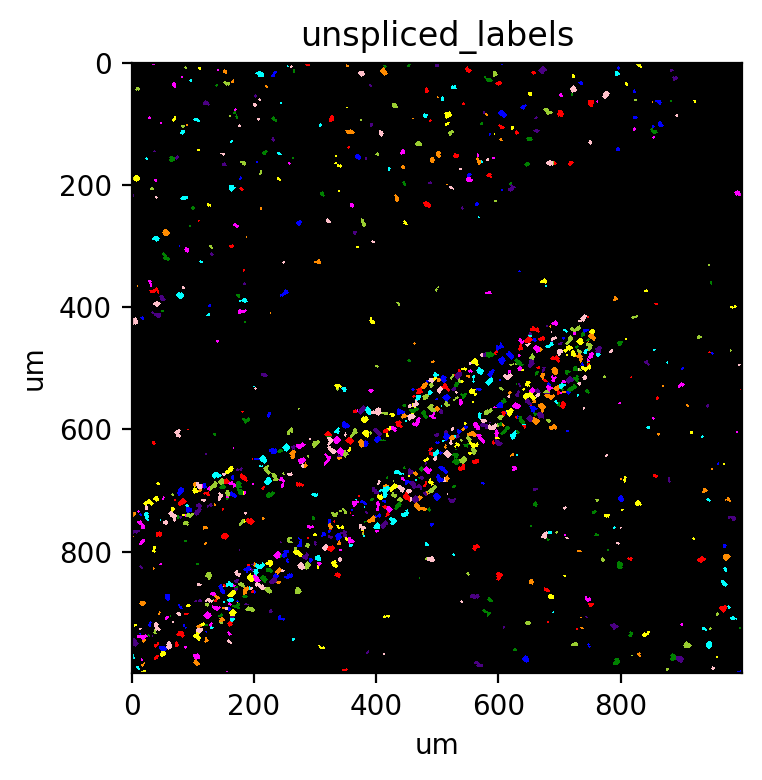

In [13]:
st.pp.segmentation.label_connected_components(adata, 'unspliced')
st.pl.imshow(adata, 'unspliced_labels', labels=True)

## 2. Cell segmentation

In this section, we use the labeled nuclei obtained above to guide our quest to identify individual cells.

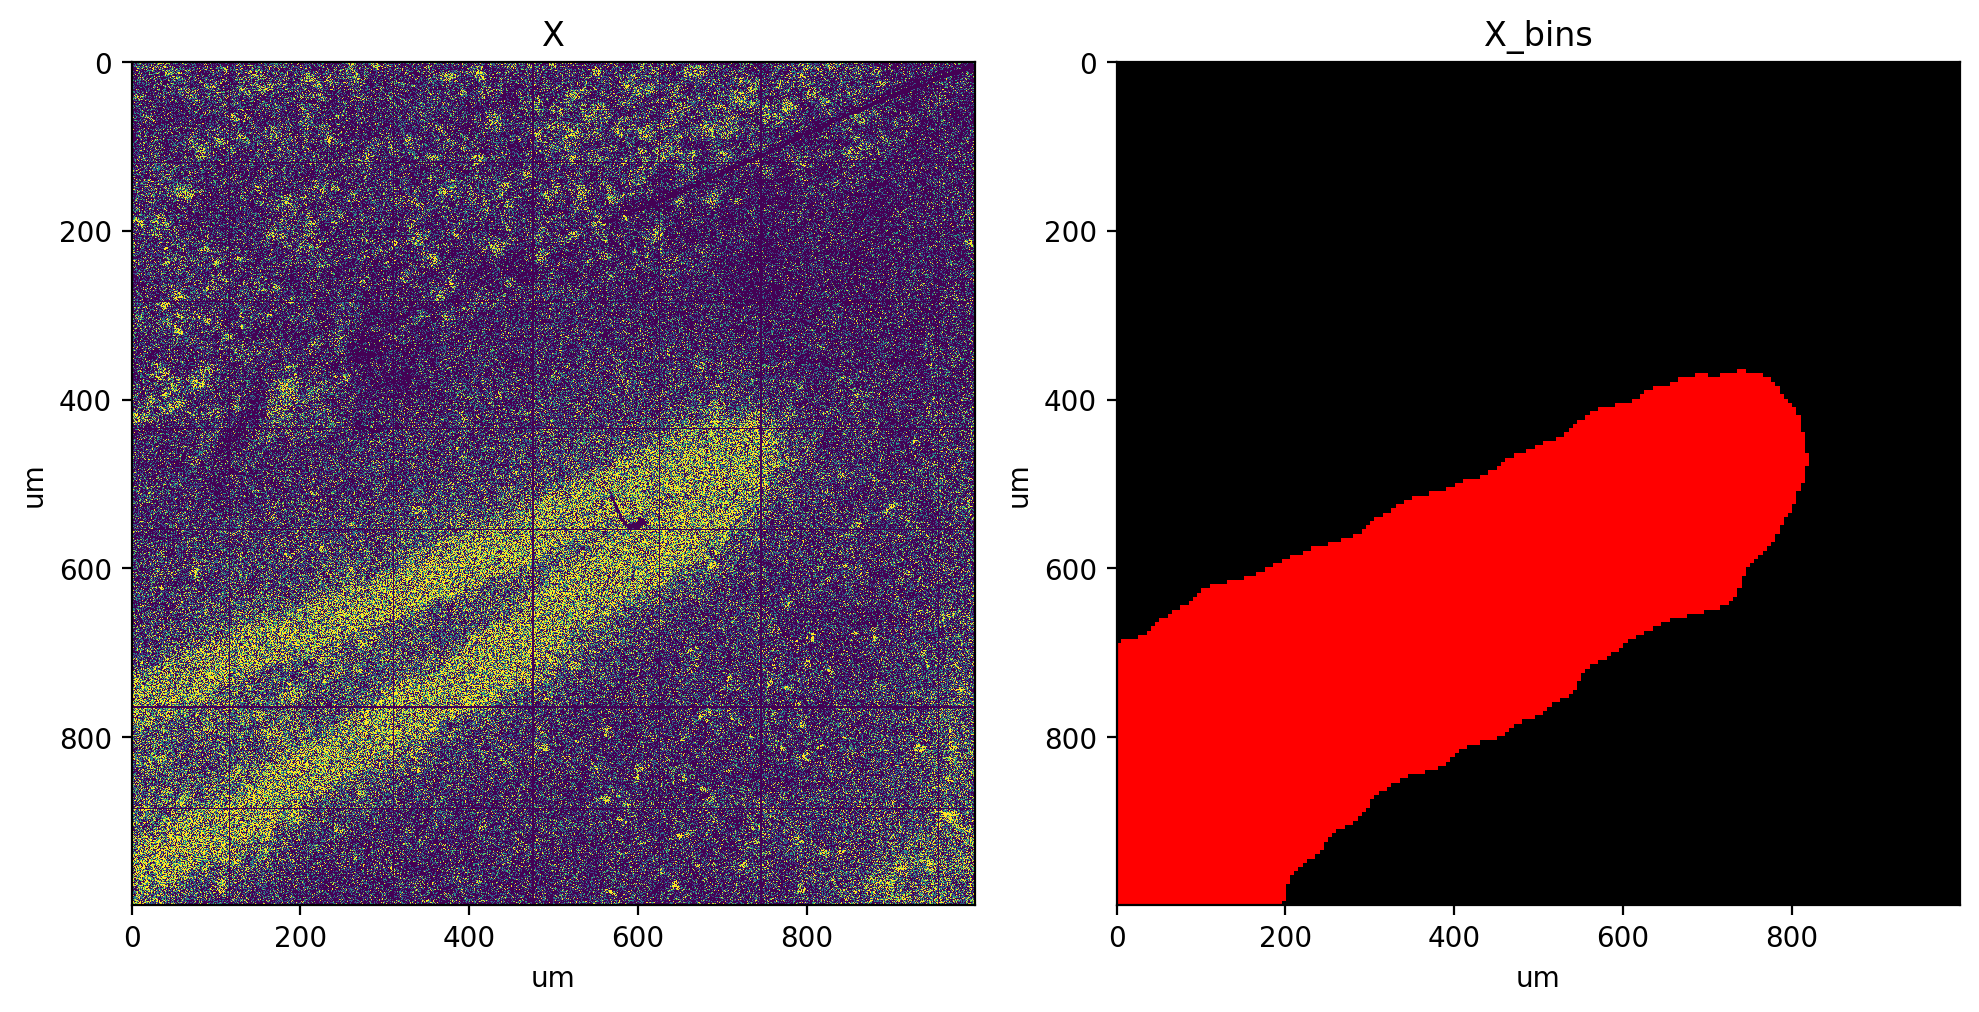

In [14]:
st.pp.segmentation.segment_densities(adata, 'X', 10, k=5, distance_threshold=10, dk=21)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'X', vmax=5, ax=axes[0])
st.pl.imshow(adata, 'X_bins', ax=axes[1], labels=True)

In the proceeding cell, notice the `certain_layer='unspliced_labels'` argument, which indicates the layer in the AnnData that contains the nuclei labels obtained from unspliced RNA signal.

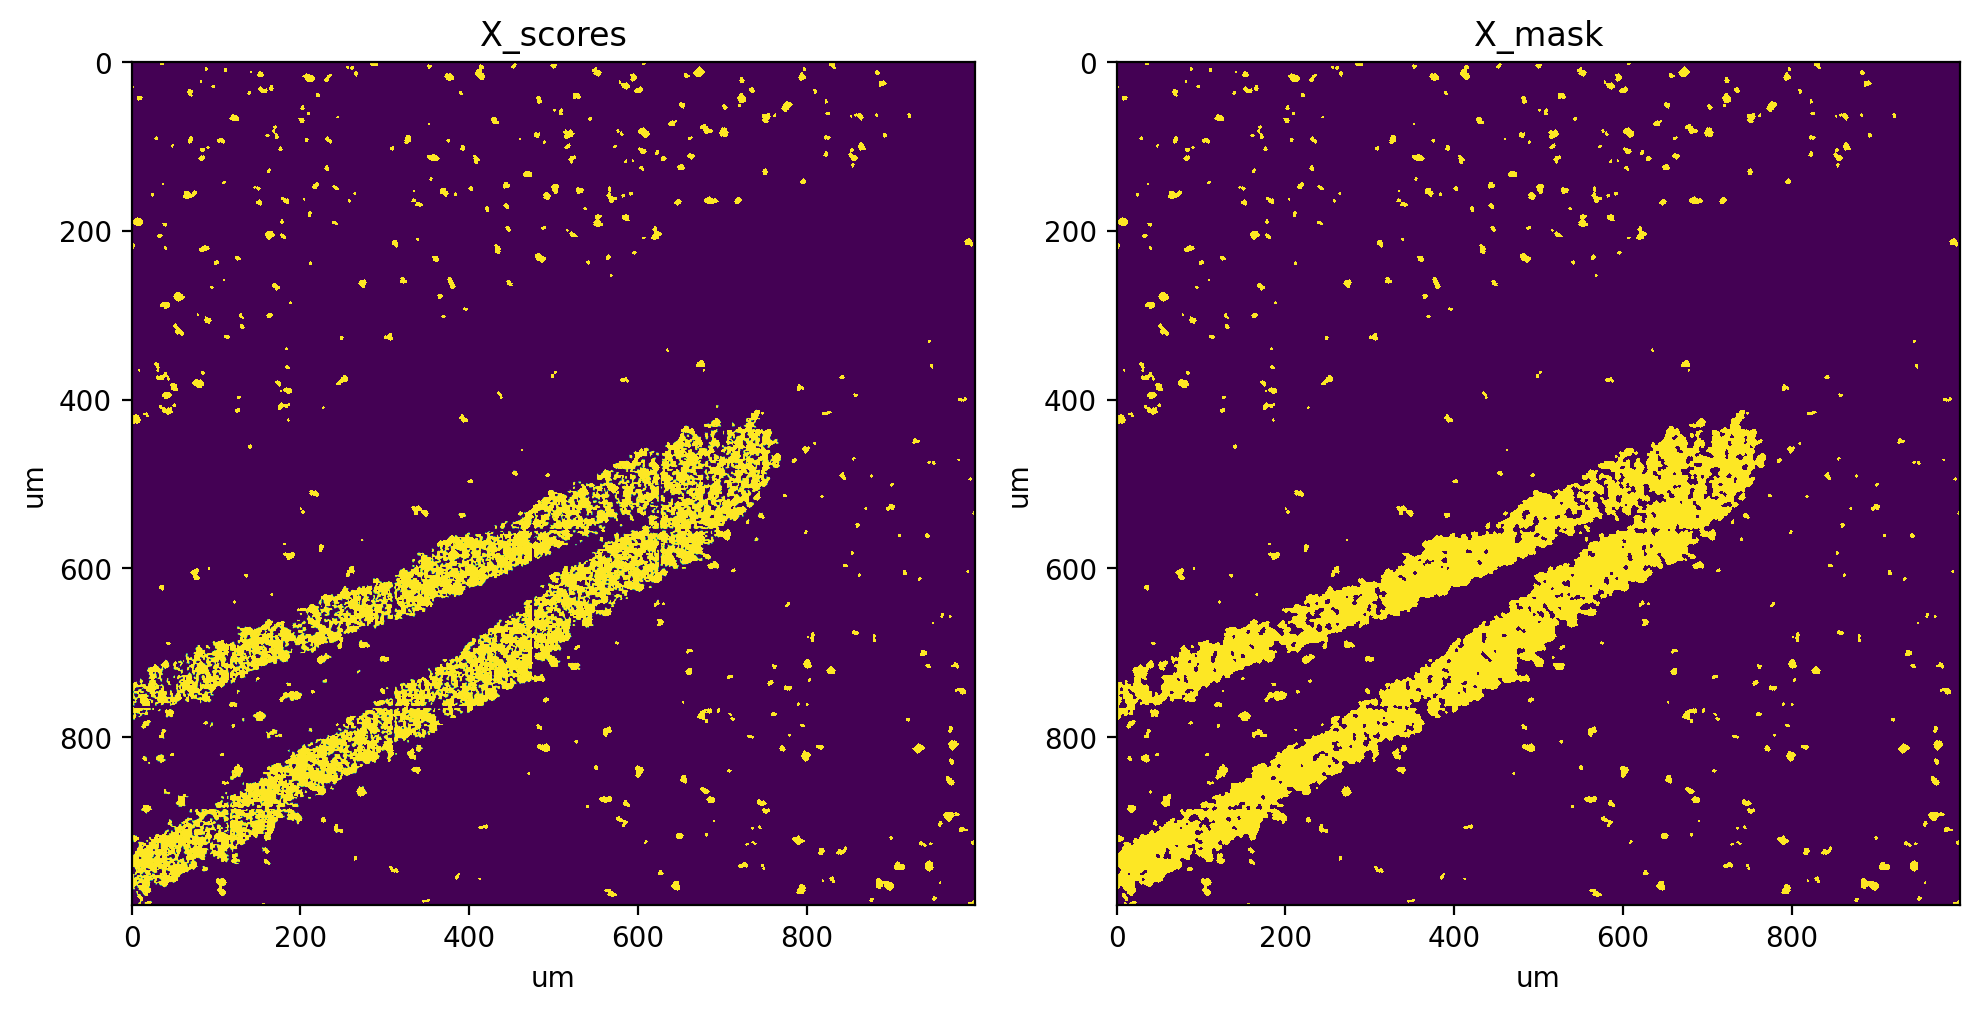

In [15]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=5, method='EM+BP',
    em_kwargs=dict(downsample=0.01, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=0.9, q=0.1),
    certain_layer='unspliced_labels'
)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'X_scores', ax=axes[0])
st.pl.imshow(adata, 'X_mask', ax=axes[1])

Finally, expand the nuclei labels so that each cell occupies up to a certain distance from the nucleus, while constraining the problem within the mask obtained in the previous cell.

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'X_labels'}, xlabel='um', ylabel='um'>)

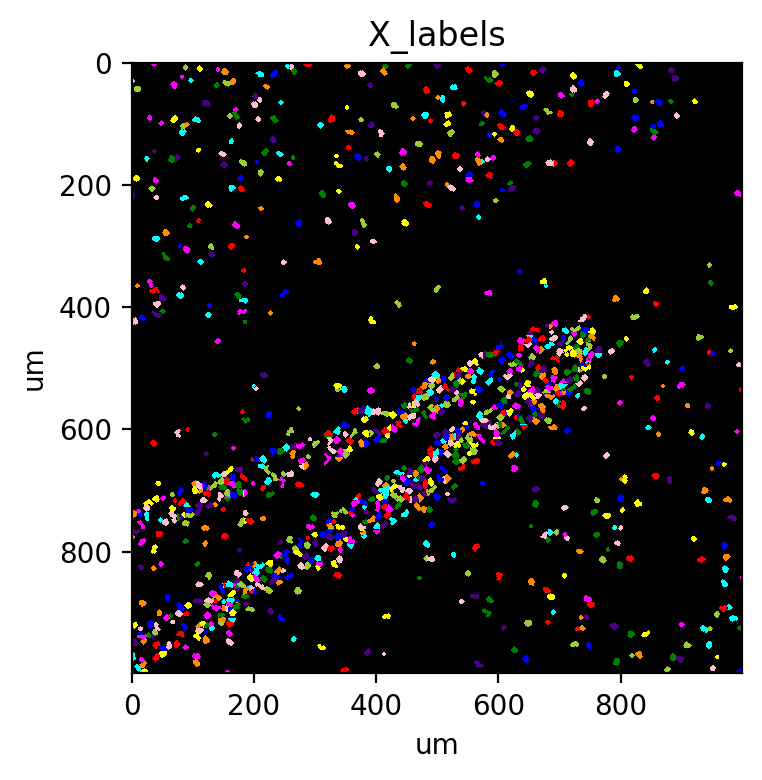

In [18]:
st.pp.segmentation.expand_labels(
    adata, 'unspliced', distance=5, max_area=400, mask_layer='X_mask', out_layer='X_labels'
)
st.pl.imshow(adata, 'X_labels', labels=True)

In [19]:
adata.write('data/rna_segmentation.h5ad', compression='gzip')